<a href="https://colab.research.google.com/github/aditis1204/Hypespectral_Visualization_Classification/blob/master/Hypespectral_CNN(2d_%2B3d).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spectral
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

     |████████████████████████████████| 215kB 7.0MB/s 


In [2]:

!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"


!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"

--2020-08-19 09:22:51--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  1.55MB/s    in 4.0s    

2020-08-19 09:22:56 (1.41 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-08-19 09:22:59--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-08-19 09:22:59 (152 MB/s) - ‘Indian_pines_gt

In [3]:

test_ratio = 0.7
windowSize = 25

In [4]:

## Importing Library.
from scipy.io import loadmat
def loadData():
  dataset = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  labels = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  return dataset, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
def applyPCA(X, numComponents=150):
    newX = np.reshape(X, (-1, X.shape[2]))
    #pca = KernelPCA(n_components=numComponents, kernel='poly',eigen_solver='arpack')
    #pca = PCA(n_components=numComponents, svd_solver='arpack')
    pca = PCA(n_components=numComponents, whiten=True)

    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:

X, y = loadData()

X.shape, y.shape

((145, 145, 200), (145, 145))

In [10]:


K = X.shape[2]

In [11]:



K = 50 
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 50)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)


X.shape, y.shape

((10249, 25, 25, 50), (10249,))

In [13]:

Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 50), (7175, 25, 25, 50), (3074,), (7175,))

In [14]:


Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 50, 1)

In [15]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [16]:
S = windowSize
L = K
output_units =  16

In [17]:


## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 38, 32)


In [18]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 50, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 44, 8)     512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 40, 16)    5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 38, 32)    13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 1216)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        700480    
_________________________________________________________________
flatten (Flatten)            (None, 18496)            

In [19]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:

# checkpoint
filepath = "/content/drive/My Drive/Colab Notebooks/best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=50, callbacks=callbacks_list)

Epoch 1/50
13/13 [==============================] - 13s 992ms/step - loss: 2.7533 - accuracy: 0.1552
Epoch 2/50
13/13 [==============================] - 13s 1s/step - loss: 2.4765 - accuracy: 0.1897
Epoch 3/50
13/13 [==============================] - 13s 1s/step - loss: 2.4277 - accuracy: 0.2108
Epoch 4/50
13/13 [==============================] - 13s 1s/step - loss: 2.2127 - accuracy: 0.2043
Epoch 5/50
13/13 [==============================] - 13s 1s/step - loss: 1.9637 - accuracy: 0.3312
Epoch 6/50
13/13 [==============================] - 13s 1s/step - loss: 1.5342 - accuracy: 0.4522
Epoch 7/50
13/13 [==============================] - 13s 1s/step - loss: 1.4006 - accuracy: 0.5039
Epoch 8/50
13/13 [==============================] - 13s 1s/step - loss: 1.0512 - accuracy: 0.6461
Epoch 9/50
13/13 [==============================] - 13s 1s/step - loss: 0.7300 - accuracy: 0.7531
Epoch 10/50
13/13 [==============================] - 13s 1s/step - loss: 0.6978 - accuracy: 0.7632
Epoch 11/50
13/1

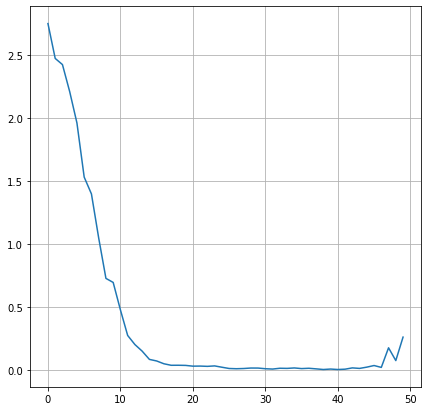

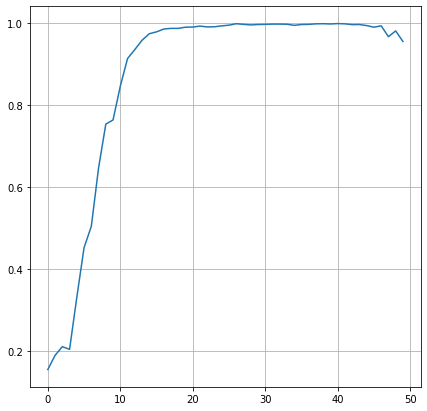

In [22]:

plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])


plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['accuracy'])



In [23]:

Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 50, 1)

In [24]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [25]:

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.84      0.92        32
           1       0.95      0.97      0.96      1000
           2       0.99      0.92      0.95       581
           3       1.00      0.97      0.98       166
           4       0.95      1.00      0.97       338
           5       0.98      1.00      0.99       511
           6       0.95      1.00      0.98        20
           7       0.99      1.00      0.99       335
           8       0.78      1.00      0.88        14
           9       0.99      0.93      0.96       680
          10       0.97      0.99      0.98      1719
          11       0.99      0.95      0.97       415
          12       0.76      1.00      0.86       143
          13       1.00      0.97      0.98       886
          14       0.97      0.98      0.98       270
          15       0.96      0.98      0.97        65

    accuracy                           0.97      7175
   macro avg       0.95   

In [26]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:

def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives','Stone-Steel-Towers']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    print(f'Accuracy: {Test_accuracy}')
    #return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
reports(Xtest,ytest)

225/225 [==============================] - 13s 57ms/step - loss: 0.1015 - accuracy: 0.9709
Accuracy: 97.0871090888977


In [31]:

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [32]:
X, y = loadData()

In [33]:

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [34]:

X,pca = applyPCA(X, numComponents=numComponents)

In [35]:

X = padWithZeros(X, PATCH_SIZE//2)

In [36]:

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

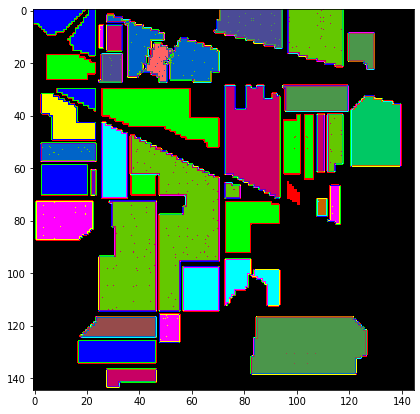

In [37]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7),cmap='jet')

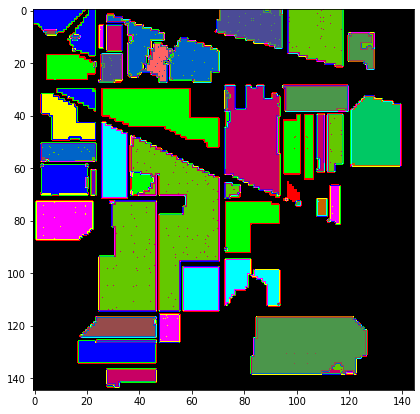

In [38]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [39]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [40]:



spectral.save_rgb(str("ind")+"_ground_truth.jpg", y, colors=spectral.spy_colors)